In [4]:
# import tensorflow as tf
# import numpy as np
# import pandas as pd
# import gc, os
# import copy
# from joblib import load, dump
# import librosa.display

from AudioPreprocessing import split_audio_file
from tqdm import tqdm
from scipy import signal as sci_signal
import matplotlib.pyplot as plt

import cv2


ModuleNotFoundError: No module named 'librosa'

In [3]:
img_shape = 256

train_path = '/kaggle/input/birdclef-2023/train_audio/'
columns = pd.read_csv('/kaggle/input/birdclef-2023/sample_submission.csv').columns[1:]

train = pd.read_csv('/kaggle/input/birdclef-2023/train_metadata.csv')
train = train.drop(columns = ['secondary_labels', 'type', 'latitude', 'scientific_name', 'common_name', 'author', 'license', 'url'])
train.head()

,primary_label,longitude,rating,filename
0,abethr1,38.2788,4.0,abethr1/XC128013.ogg
1,abethr1,38.2921,3.5,abethr1/XC363501.ogg
2,abethr1,38.2921,3.5,abethr1/XC363502.ogg
3,abethr1,38.2921,5.0,abethr1/XC363503.ogg
4,abethr1,38.2921,4.5,abethr1/XC363504.ogg


In [4]:
print(train.shape)
train = train[train.rating>0.5]
train.shape

(16941, 4)


(16399, 4)

In [5]:
train_path = '/kaggle/input/birdclef-2023/train_audio/'
columns = pd.read_csv('/kaggle/input/birdclef-2023/sample_submission.csv').columns[1:]

In [6]:
columns_to_labels = {}
for h,i in enumerate(sorted(columns)):
    if i not in columns_to_labels:
        columns_to_labels[i] = h

In [8]:
def spects_from_audios(auds, reshape = img_shape):
    '''
        list of 5 scond audio files
    '''
    Spectrograms = []
    
    for row in (auds):
        
        mean_signal = np.nanmean(row)
        audio_data = np.nan_to_num(row, nan=mean_signal) if np.isnan(row).mean() < 1 else np.zeros_like(row)

        frequencies, times, spec_data = sci_signal.spectrogram(
            audio_data, 
            fs=  32000 ,
            nfft= 1095, 
            nperseg= 412, 
            noverlap= 100, 
            window='hann'
        )
        
        valid_freq = (frequencies >= 100) & (frequencies <= 15000)
        spec_data = spec_data[valid_freq, :]

        spec_data = np.log10(spec_data + 1e-20)

        spec_data = spec_data - spec_data.min()
        spec_data = spec_data / spec_data.max()
        
        spec_data = cv2.resize(spec_data, (img_shape, img_shape), interpolation=cv2.INTER_AREA)
        Spectrograms.append(spec_data)
        
    Spectrograms = np.asarray(Spectrograms)
    return Spectrograms

In [9]:
from joblib import Parallel, delayed

class TrainDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data = train.values, batch_size=32, ):
        
        self.x_data = x_data
        self.batch_size = batch_size  
        self.indices = np.arange(len(self.x_data))
    
    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))
    
    
    def __getitem__(self, index):
        
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        x_batch, y_batch = self.convert_to_spects(batch_indices)
        
        x_batch = x_batch.reshape(-1,img_shape,img_shape,1)
        return x_batch, y_batch
    
    def get_labels(self, primary_label):
        labels = np.zeros(len(columns_to_labels))
        labels[columns_to_labels[primary_label]] = 1
        return labels
    
    def convert_to_spects(self, batch_indices):
        
        sr = 32000
        x = []
        oup = []
        
        for k,i in enumerate(batch_indices):
            
            audio_file = train_path + self.x_data[i][3]
            primary_label =   self.x_data[i][0]
            y, _ = librosa.load(audio_file, sr=sr)
            total_duration = len(y) / sr
            
            while total_duration < 5:
                y = np.concatenate([y, y])
                total_duration = len(y) / sr
                
            start_idx = int((total_duration / 2 - 2.5) * sr)
            middle_5_seconds = y[start_idx:start_idx + 5 * sr]
            early_5_sec = y[0:5*sr]

            x.append(middle_5_seconds)
            x.append(early_5_sec)
            
            labels = self.get_labels(primary_label)
            oup.append([labels]*2)
            
        return spects_from_audios(x), np.vstack(oup)
    
    def on_epoch_end(self):
        pass

(64, 256, 256, 1) (64, 264)


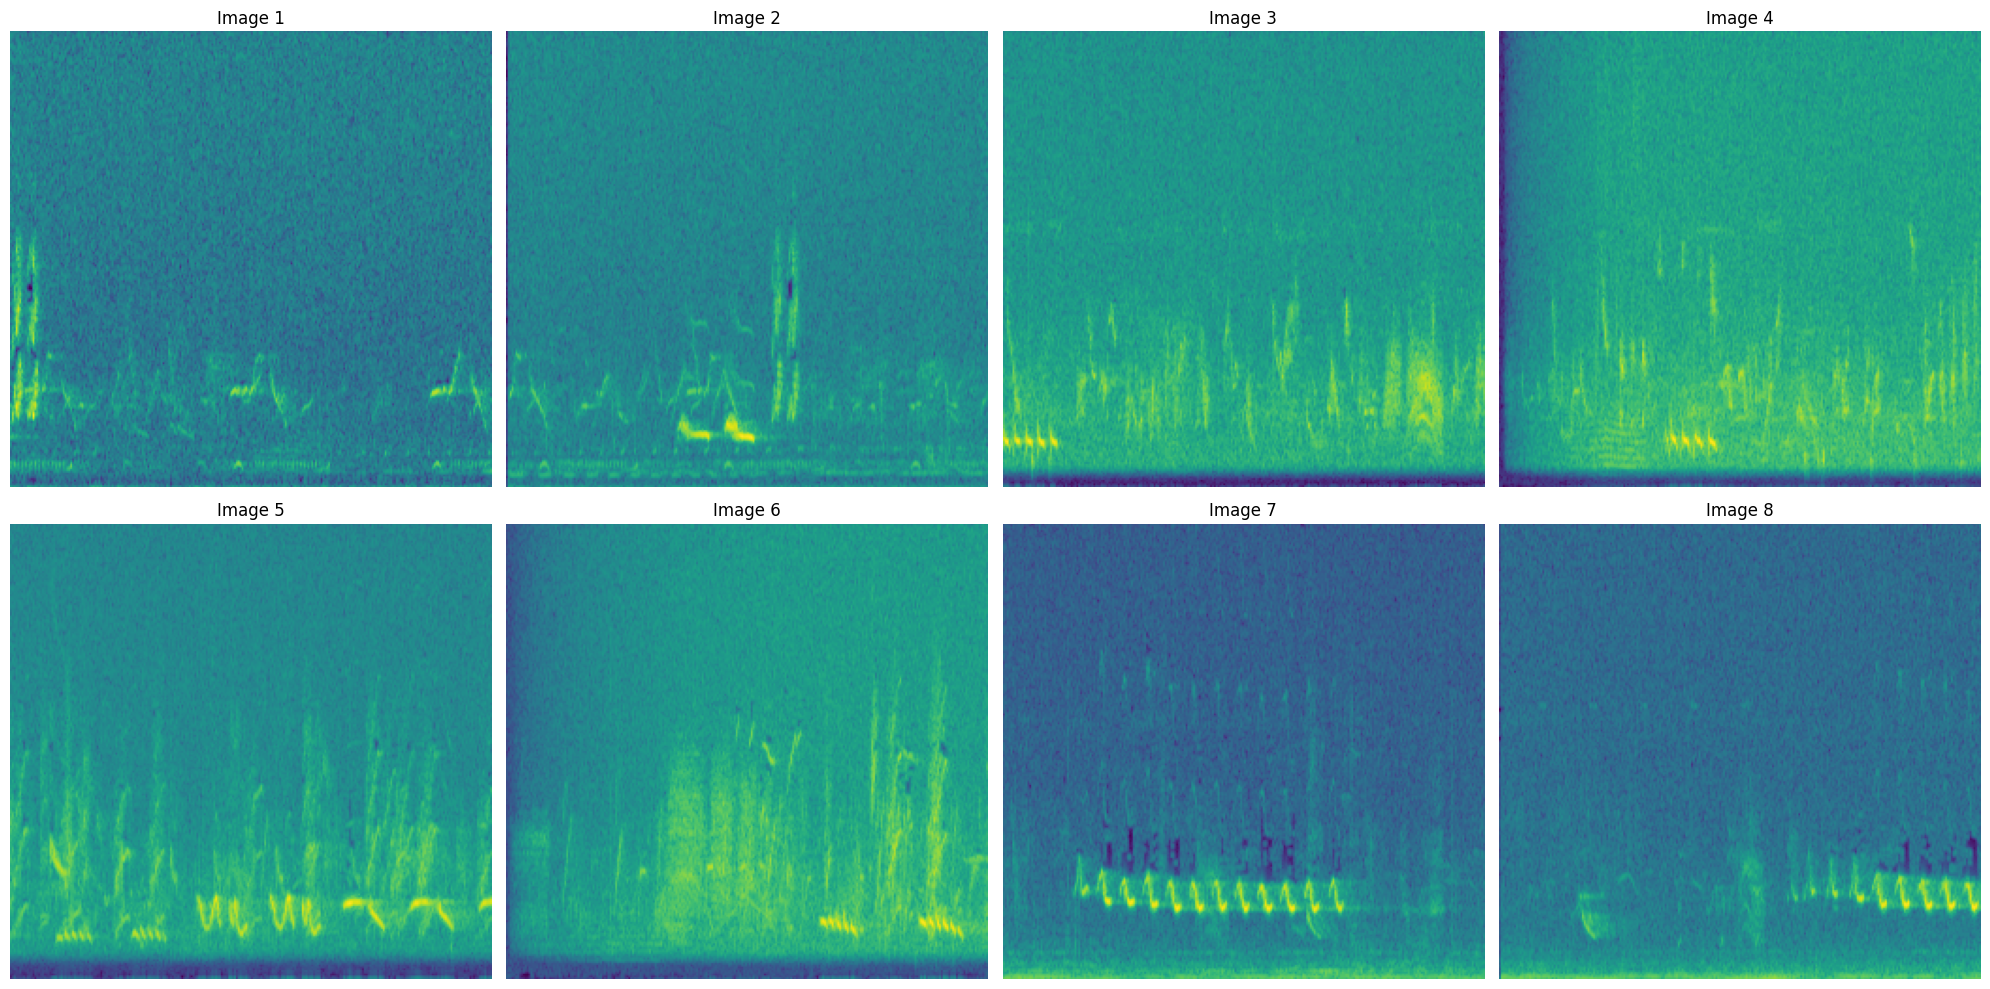

In [14]:
gen = TrainDataGenerator()

for x_batch, y_batch in (gene):
    
    print(x_batch.shape, y_batch.shape,)
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i, image in enumerate(x_batch[0:8]):
        ax = axs[i // 4, i % 4]
        ax.imshow(image, aspect='auto', origin='lower', cmap='viridis')
        ax.set_title(f'Image {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    break

In [17]:
x, y = [], []

for i in tqdm(gen):
    x.append(i[0])
    y.append(i[1])
    
x = np.vstack(x)
y = np.vstack(y)

  0%|          | 0/513 [00:01<?, ?it/s]


In [18]:
print(x.shape, y.shape)

(64, 256, 256, 1) (64, 264)
